In [ ]:
import os, fnmatch
import pandas as pd
import numpy as np
from datetime import datetime
from plotnine import *
#Variables to define
path = "/Users/eric1999/Desktop/mantis/"
filename = "timeseries.csv"
target = "Sales"
Date = "Date"
date_train_init = "2013-01-01"
date_train_end = "2015-07-31"
date_forecast_init = "2015-08-01"
date_forecast_end = "2016-01-01"
kmin = 0.25
frequency = "D"
groupby = "Store"

#Loading functions. Should be included in a dependencies file and prob under a clarr object
def ImportDataCSV(path, filename, Date):
    if fnmatch.filter(os.listdir(path), str(filename)) != "[]":
        data = pd.read_csv(path + str(filename), 
                    parse_dates = True, low_memory = False, index_col = 0)
    else:
        print("The input file does not correspond to filename")
    
    return(data)

def CompleteMissingDates(ts, date_train_init, date_train_end, frequency):
    TimeRange = pd.date_range(start=date_train_init,end=date_train_end, freq = frequency)
    frames = []
    for i in np.unique(ts[groupby]):
        a = ts.loc[ts[groupby] == i,]
        a .index = pd.DatetimeIndex(a.Date)
        a.pop(Date)
        a  = a.reindex(TimeRange)
        a[Date] = np.array(a.index)
        a[[groupby]] = a[[groupby]].fillna(method='ffill')
        a.reset_index(drop=True, inplace=True)
        frames.append(a)
    ts = pd.concat(frames)
    return(ts)

def Less50InLast25Perc(ts, date_train_init, date_train_end, frequency, perc = 0.25, threshold = 0.5):
    TimeRange = pd.date_range(start=date_train_init,end=date_train_end, freq = frequency)
    CompleteArray = len(pd.date_range(start=date_train_init,end=date_train_end, freq = frequency))
    TimeRange = TimeRange[int(round(CompleteArray - CompleteArray * 0.25,0)):CompleteArray]

    remove = []
    for i in np.unique(ts[groupby]):
        TotalNA = ts.loc[(ts[groupby] == i) & (ts[Date] >= TimeRange[0]), target].isna().sum()
        RatioNA = TotalNA / len(ts.loc[(ts[groupby] == i) & (ts[Date] >= TimeRange[0]), target])
        if(RatioNA > threshold):
            remove.append(i)
    
    return(remove)


def MissingLastObs(ts, date_train_init, date_train_end, frequency, last_obs = 10):
    TimeRange = pd.date_range(start=date_train_init,end=date_train_end, freq = frequency)
    remove = []
    for i in np.unique(ts[groupby]):
        TotalNA = ts.loc[(ts[groupby] == i) & (ts[Date] >= TimeRange[-last_obs]), target].isna().sum()
        if TotalNA != 0:
            remove.append(i)

    return(remove)

def MissingCheck(ts, date_train_init, date_train_end, frequency, ):
    #Copy of the original data
    ts.OriginalData = ts
    #Complete the missing dates
    ts.CompleteData = CompleteMissingDates(ts, date_train_init, date_train_end, frequency)

    #Less than 50% in the last 25%
    ts.Less50InLast25 = Less50InLast25Perc(ts.CompleteData, date_train_init, date_train_end, frequency, perc = 0.25, threshold = 0.5)
    ts.CompleteData = ts.CompleteData [~ts.CompleteData[groupby].isin(Less50Obs)]

    ts.MissingLastOb = MissingLastObs(ts.CompleteData, date_train_init, date_train_end, frequency, last_obs = 10)
    ts.CompleteData = ts.CompleteData[~ts.CompleteData[groupby].isin(MissingsLast)]

    return(ts)

def PlotData(ts, idx, Date, target, date_start, date_end):
    ts_subset = ts.loc[(ts[groupby] == idx) & (ts[Date] >= date_start) & (ts[Date] <= date_end),]
    plot_list = ( ggplot(ts_subset, aes(x=Date, y=target))
    + geom_line() # line plot
    + labs(x=Date, y=target)
    )

    return(plot_list)

In [185]:
#Gather data
ts = ImportDataCSV(path, filename, Date)
ts.index = pd.DatetimeIndex(ts.Date)
ts.resample(frequency).mean()

#Data Processing
ts = MissingCheck(ts, date_train_init, date_train_end, frequency)

<ipython-input-184-a9f5165e5533>:70: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
<ipython-input-184-a9f5165e5533>:72: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
<ipython-input-184-a9f5165e5533>:75: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
<ipython-input-184-a9f5165e5533>:78: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [194]:
#Check complete data
ts.CompleteData

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Date
0,1.0,2.0,0.0,0.0,0.0,0.0,a,1.0,2013-01-01
1,1.0,3.0,5530.0,668.0,1.0,0.0,0,1.0,2013-01-02
2,1.0,4.0,4327.0,578.0,1.0,0.0,0,1.0,2013-01-03
3,1.0,5.0,4486.0,619.0,1.0,0.0,0,1.0,2013-01-04
4,1.0,6.0,4997.0,635.0,1.0,0.0,0,1.0,2013-01-05
...,...,...,...,...,...,...,...,...,...
937,50.0,1.0,6684.0,464.0,1.0,1.0,0,1.0,2015-07-27
938,50.0,2.0,5115.0,390.0,1.0,1.0,0,1.0,2015-07-28
939,50.0,3.0,4946.0,379.0,1.0,1.0,0,1.0,2015-07-29
940,50.0,4.0,5324.0,376.0,1.0,1.0,0,1.0,2015-07-30


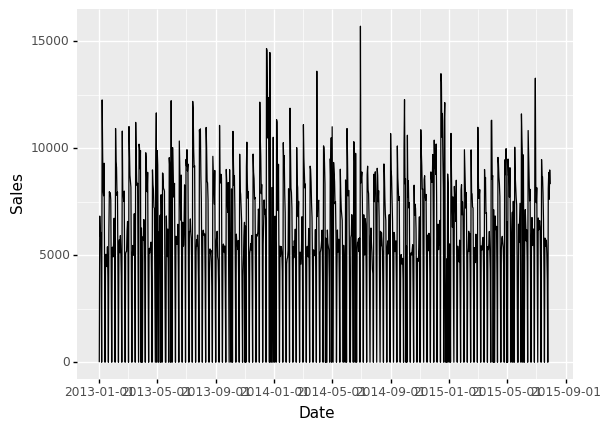

<ggplot: (8781308932106)>

In [190]:
#Plotting one of the ids with the target vars
PlotData(ts = ts.CompleteData, idx = 3, Date = Date, target = target, date_start = date_train_init, date_end = date_train_end)